In [2]:
# Run this first!!!
from IPython.display import display, HTML

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson

import sys
sys.path.append('../experimental')
from size_model import SizeModel
sys.path.append('../common')
import util
import common_probs
from sampler import DepthSampler

In [3]:
def plot_avg_trend(alph_sizes, length, num_samples):
    avgs = []
    for size in alph_sizes:
        probs = [0.5 for _ in xrange(size)]
        avgs.append(get_long_time_avg(probs, length, num_samples))
    plt.plot(alph_sizes, avgs)
    plt.xlabel('Alphabet Size')
    plt.ylabel('Mean Offspring')
    plt.title('Mean Offspring vs Alphabet Size')
    plt.show()

def get_long_time_avg(probs, length, num_samples):
    ds = DepthSampler(probs, length)
    df = ds.draw_samples(num_samples, ['thread_children'])
    offsprings = df[df['depth'] == length - 1]['thread_children']
    offsprings = offsprings.map(lambda l: 0 if len(l) == 0 else sum(l) / len(l))
    return offsprings.mean()

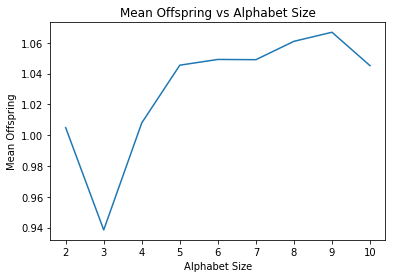

In [31]:
# Parameters
ALPH_SIZES = range(2, 11)
LENGTH = 50
NUM_SAMPLES = 1000

plot_avg_trend(ALPH_SIZES, LENGTH, NUM_SAMPLES)

## Model Adjustment

At this point I realized I might be trying to make things too complicated. Really the purpose of this model is to find the long term average of states per depth. To do this we only need to find the two averages $\mu_X$ and $\mu_Y$. However, when plugging in the values that were found in last week's notebook it overestimates the long term average by quite a bit. Can the model be adjusted so that the values that we sample work out?

## How close is the original model?

Let's run calculations to find how close the original model is to predicting the asymptotic mean of states per depth.

In [38]:
def sample(probs, length, num_samples):
    ds = DepthSampler(probs, length)
    return ds.draw_samples(num_samples, ['threads', 'thread_children', 'new_thread'])

def compute_asym_avg_new_threads(df, length):
    return df[df['depth'] == length - 1]['new_thread'].mean()

def compute_asym_avg_offspring(df, length):
    total_offspring = df[df['depth'] == length - 1]['thread_children'].map(sum).sum()
    num_threads = df[df['depth'] == length - 1]['threads'].sum()
    return total_offspring / num_threads

def compute_asym_avg_threads(df, length):
    return df[df['depth'] == length - 1]['threads'].mean()

def compute(probs, length, num_samples):
    df = sample(probs, length, num_samples)
    mu_x = compute_asym_avg_new_threads(df, length)
    mu_y = compute_asym_avg_offspring(df, length)
    print 'Mu_x = %f' % mu_x
    print 'Mu_y = %f' % mu_y
    if mu_y >= 1:
        print 'Mu_y >= 1: Geometric series does not converge.'
    else:
        print 'Theoretical limE[Z_n]: %f' % (mu_x / (1 - mu_y))
        print 'Sampled limE[Z_n]: %f' % compute_asym_avg_threads(df, length)

In [39]:
# PARAMETERS
PROBS = [0.5 for _ in range(4)]
LENGTH = 50
SAMPLES = 1000

compute(PROBS, LENGTH, SAMPLES)

Mu_x = 0.646000
Mu_y = 0.956789
Theoretical limE[Z_n]: 14.949900
Sampled limE[Z_n]: 5.531000


So you can see the model actually is not very good at predicting asymptotic mean yet. Somehow in the picture that the model paints we are producing much more states. Need to brainstorm reasons for this. Some possibilities I can think of right now are...

1. We are not accounting enough for threads merging together.
2. The model assumes that these averages are constant throughout the lifetime of the process. However, we have seen that in reality there is some "ramp-up" period where the averages increase to these values. It could be that by assuming these averages are high from the start we accumulate more states and the long time average is also high. This seems unlikely to me though because asymptotically I would think this would have little effect.

### Adding a Merge Term (Doesn't end up working)

One thing that I realized might help is adding a term that accounts for threads merging together. Let $M_n$ be the number of threads that have been merged together at depth $n$. The new model can then be formulated as...

$$
Z_{n + 1} = X_{n + 1} - M_{n + 1} + \sum_{i=1}^{Z_n} Y_i
$$

Of course now $M_{n}$ has an intertwined relationship with the other random variables $X$ and $Y$s take since the number of states we have in a depth cannot be negative. That is, the support of $M_n$ is $\{0, \ldots, X_n + \sum_{i=1}^{Z_n} Y_i\}$. Because of this, it is unlikely that $M_n$ is time-homogenous. For now to get around this, let's just try to use $M_n$ as if it is a normal random variable and see if this is a better fitting model. With this assumption made now note that...

$$
\lim_{n \rightarrow \infty} Z_n = \frac{\mu_X - \mu_M}{1 - \mu_Y}
$$

One other adjustment that must be made with this is before with the offspring, I was only counting each child once. In other words, if a thread was merged into another thread the child would only count for one of the threads so that there was no double counting. With this addition though we must change that.

Now let's sample these values, plug them into the formula, and see how they compare to the long term average.

In [40]:
def sample(probs, length, num_samples):
    ds = DepthSampler(probs, length)
    return ds.draw_samples(num_samples, ['threads', 'total_children', 'new_thread', 'merge_degree'])

def compute_asym_avg_new_threads(df, length):
    return df[df['depth'] == length - 1]['new_thread'].mean()

def compute_asym_avg_offspring(df, length):
    total_offspring = df[df['depth'] == length - 1]['total_children'].map(sum).sum()
    num_threads = df[df['depth'] == length - 1]['threads'].sum()
    return total_offspring / num_threads

def compute_asym_avg_merged(df, length):
    total_merged = df[df['depth'] == length - 1]['merge_degree'].map(sum).sum()
    num_threads = df[df['depth'] == length - 2]['total_children'].map(sum).sum()
    return total_merged / num_threads

def compute(probs, length, num_samples):
    df = sample(probs, length, num_samples)
    mu_x = compute_asym_avg_new_threads(df, length)
    mu_y = compute_asym_avg_offspring(df, length)
    mu_m = compute_asym_avg_merged(df, length)
    print 'Mu_x = %f' % mu_x
    print 'Mu_y = %f' % mu_y
    print 'Mu_m = %f' % mu_m
    if mu_m > mu_x:
        print 'Mu_m > Mu_x: Negative mean results.'
    elif mu_y >= 1:
        print 'Mu_y >= 1: Geometric series does not converge.'
    else:
        print 'lim E[Z_n] = %f' % (mu_x - mu_m) / (1 - mu_y)

In [41]:
# PARAMETERS
PROBS = [0.5 for _ in range(4)]
LENGTH = 50
SAMPLES = 100

compute(PROBS, LENGTH, SAMPLES)

Mu_x = 0.660000
Mu_y = 1.593878
Mu_m = 0.400251
Mu_y >= 1: Geometric series does not converge.


One thing that I did not consider is that with the adjustment to how we count offspring, the geometric series no longer converges. In order to fix this we would have to consider the amount of merged states in the sum so that the average would be lower and the series would converge. However, this is pretty much the old model so really no progress was made here.

## More Attempts at Diagnosing the Problem

In order to get a better picture at what might be going wrong, we can plot the actual sampled DFA mean along with the model. For the offspring distribution we will use a Poisson distribution since it is easy to get the mean and the offspring looked approximately Poisson before.

In [56]:
def plot_trends(probs, length, num_samples, mu_x, mu_y):
    depths = range(1, length + 1)
    alg_trend = get_alg_trend(probs, length, num_samples)[1:]
    plt.plot(depths, alg_trend, label='Algorithm')
    pois = approximate_poisson_dist(mu_y, len(probs))
    model_trend = get_model_trend(num_samples, length, mu_x, pois)
    plt.plot(depths, model_trend, linestyle='--', label='Model')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Depth')
    plt.ylabel('Average Number of Threads')
    plt.title('Average Number of Threads vs Depth')
    plt.show()
    
def get_alg_trend(probs, length, num_samples):
    ds = DepthSampler(probs, length)
    df = ds.draw_samples(num_samples, ['threads'])
    return df.groupby('depth')['threads'].mean().tolist()
    
def get_model_trend(num_samples, length, mu_x, dist):
    model = SizeModel(mu_x, dist)
    return model.do_sims(length, num_samples)

def approximate_poisson_dist(mu_y, possible_offspring):
    dist = [poisson.pmf(i, mu_y) for i in range(possible_offspring + 1)]
    dist[0] = 1 - sum(dist[1:])
    return dist

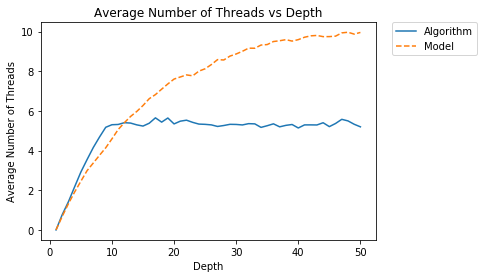

In [58]:
# PARAMETERS
PROBS = [0.5 for _ in range(4)]
LENGTH = 50
NUM_SAMPLES = 1000
MU_X = 0.65
MU_Y = 0.956

plot_trends(PROBS, LENGTH, NUM_SAMPLES, MU_X, MU_Y)

It's interesting because it seems like the start of each of the curves is about the same, and it even looks like the algorithm grows faster. But then the algorithm very suddenly stop increasing and becomes constant while the model keeps increasing.

## The Answer

So one thing I was not considering before was merges that happen with new threads which actually occurs quite frequently. Considering this we get a much more accurate depiction of what is happening.

In [2]:
# Note that this is actually the same code that appears below. Just rewriting/running it again to show change.
def sample(probs, length, num_samples):
    ds = DepthSampler(probs, length)
    return ds.draw_samples(num_samples, ['threads', 'thread_children', 'new_thread'])

def compute_asym_avg_new_threads(df, length):
    return df[df['depth'] == length - 1]['new_thread'].mean()

def compute_asym_avg_offspring(df, length):
    total_offspring = df[df['depth'] == length - 1]['thread_children'].map(sum).sum()
    num_threads = df[df['depth'] == length - 1]['threads'].sum()
    return total_offspring / num_threads

def compute_asym_avg_threads(df, length):
    return df[df['depth'] == length - 1]['threads'].mean()

def compute(probs, length, num_samples):
    df = sample(probs, length, num_samples)
    mu_x = compute_asym_avg_new_threads(df, length)
    mu_y = compute_asym_avg_offspring(df, length)
    print 'Mu_x = %f' % mu_x
    print 'Mu_y = %f' % mu_y
    if mu_y >= 1:
        print 'Mu_y >= 1: Geometric series does not converge.'
    else:
        print 'Theoretical limE[Z_n]: %f' % (mu_x / (1 - mu_y))
        print 'Sampled limE[Z_n]: %f' % compute_asym_avg_threads(df, length)

In [4]:
# PARAMETERS
PROBS = [0.5 for _ in range(4)]
LENGTH = 50
SAMPLES = 10000

compute(PROBS, LENGTH, SAMPLES)

Mu_x = 0.646900
Mu_y = 0.889491
Theoretical limE[Z_n]: 5.853844
Sampled limE[Z_n]: 5.403200


Much better! Even this seems like a pretty good accomplishment because now we have the (or an approximate) relationship between two easier to calculate expected values and a much harder one.

## Finding Upper Bound to Expected Number of States

Finding an upper bound to the expected number of states should follow naturally from this then. This is because the most that the number of states and number of threads can differ by in any given depth is 1 (i.e. differ by the state with the failure going back to the epsilon state). Also since the expected number of states in a depth seems to be monotonically increasing with depth we can say that where $S_n$ is the number of states in depth $n$ that...

$$
E[S_n] \leq \lim_{n \rightarrow \infty}E[Z_n] + 1
$$

And where $N$ is the total depth of the DFA...
$$
\sum_{n=0}^N E[S_n] \leq (N - 1)\left(\lim_{n \rightarrow \infty}E[Z_n] + 1\right) + 2
$$

In [10]:
def sample(probs, length, num_samples):
    ds = DepthSampler(probs, length)
    return ds.draw_samples(num_samples, ['states', 'threads', 'thread_children', 'new_thread'])

def compute_upperbound(df, length):
    mu_x = df[df['depth'] == length - 1]['new_thread'].mean()
    total_offspring = df[df['depth'] == length - 1]['thread_children'].map(sum).sum()
    num_threads = df[df['depth'] == length - 1]['threads'].sum()
    mu_y = total_offspring / num_threads
    return (mu_x / (1 - mu_y)) + 1

def plot_states(probs, length, num_samples):
    df = sample(probs, length, num_samples)
    states = df.groupby('depth')['states'].mean().tolist()[1:]
    depths = range(1, length + 1)
    plt.plot(depths, states)
    upper = compute_upperbound(df, length)
    plt.axhline(upper, ls='--')
    plt.xlabel('Depth')
    plt.ylabel('Average Number of States')
    plt.title('Average Number of States vs Depth')
    plt.show()

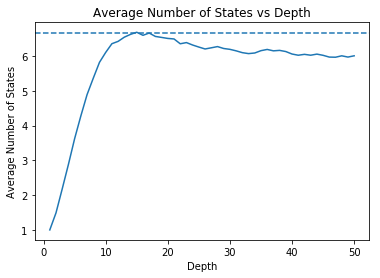

In [15]:
# PARAMETERS
PROBS = [0.5 for _ in range(4)]
LENGTH = 50
SAMPLES = 10000

plot_states(PROBS, LENGTH, SAMPLES)

So it seems that my claim might not be completely accurate. This is because I forgot that number of states is not actually monotonically increasing for some reason. Still seems very close though. 

## Next Steps
At this point, it would be great if I could find an analytical way to determine $\mu_X$ and $\mu_Y$. Before I was trying to make this too hard and find the exact distribution. However, really all that is needed is to find the expected values of each distribution, which seems like it should be more feasible to do. To do this I will most likely need to go back to the generalized string representation of things and work with probabilities there.

I should also check to make sure that things hold for different alphabets and probabilities of seeing letters.